In [1]:
#default_exp suite

# Model Suite

<br>

### Imports

In [2]:
#exports
import yaml
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split

from evtdemand import data, feature

from tqdm import tqdm
from random import randint
from typing import Protocol
from importlib import import_module

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from IPython.display import JSON

In [57]:
#exports
class ScikitModel(Protocol):
    def fit(self, X, y, sample_weight=None): ...
    def predict(self, X): ...
    def score(self, X, y, sample_weight=None): ...
    def set_params(self, **params): ...
    
def create_train_test_indexes(X, **split_kwargs):
    if 'n_splits' not in split_kwargs.keys():
        assert 'test_size' in split_kwargs.keys(), 'You must provide either `n_splits` or `test_size` within the `split_kwargs` parameters'
        size = X.shape[0]
        index_array = np.linspace(0, size-1, size).astype(int)
        train_test_indexes = [tuple(train_test_split(index_array, **split_kwargs))]
    else:
        kf = KFold(**split_kwargs)
        train_test_indexes = kf.split(X)
        
    return train_test_indexes
    
def calculate_error_metrics(y1, y2, y1_pred, y2_pred, y_baseline):
    baseline_combined_rmse = np.sqrt(np.square(y_baseline - y1).sum() + np.square(y_baseline - y2).sum())
    combined_rmse = np.sqrt(np.square(y1_pred - y1).sum() + np.square(y2_pred - y2).sum())
    
    error_metrics = {
        'y1_rmse': np.sqrt(np.square(y1_pred - y1).sum()),
        'y2_rmse': np.sqrt(np.square(y2_pred - y2).sum()),
        'combined_rmse': combined_rmse,
        'skill_score': combined_rmse/baseline_combined_rmse
    }

    return error_metrics

def construct_prediction_df(
    y1_pred: np.ndarray,
    y2_pred: np.ndarray,
    index: pd.Index,
    df_features: pd.DataFrame
):
    df_pred = pd.DataFrame({'value_max': y1_pred, 'value_min': y2_pred}, index=index)
    df_pred.index.name = 'time'
    df_pred.index = index.tz_convert(None)
    
    # handling invalid values
    invalid_max_idxs = df_pred.index[~(df_features['value'].values < df_pred['value_max'].values)]
    invalid_min_idxs = df_pred.index[~(df_features['value'].values > df_pred['value_min'].values)]
    
    if len(invalid_max_idxs) > 0:
        df_pred.loc[invalid_max_idxs, 'value_max'] = df_features.loc[invalid_max_idxs.tz_localize('UTC'), 'value'].values
        
    if len(invalid_min_idxs) > 0:
        df_pred.loc[invalid_min_idxs, 'value_min'] = df_features.loc[invalid_min_idxs.tz_localize('UTC'), 'value'].values

    # final checks
    assert df_pred.isnull().sum().sum() == 0, 'There should be no NaN values in the predictions'
    
    return df_pred

class ModelSuite:
    def __init__(
        self,
        model_1: ScikitModel=RandomForestRegressor(),
        model_2: ScikitModel=RandomForestRegressor(),
    ):
        self.set_models(model_1, model_2)
        
        return
    
    def set_models(
        self,
        model_1: ScikitModel=RandomForestRegressor(),
        model_2: ScikitModel=RandomForestRegressor(),
        trained: bool=False
    ):
        self.model_1 = model_1
        self.model_2 = model_2
        
        self.trained = trained
        
        return 
    
    def fit_models(
        self,
        X: np.ndarray,
        y1: np.ndarray,
        y2: np.ndarray,
        shuffle=True,
    ):
        if shuffle == True:
            shuffler = np.random.permutation(X.shape[0])
            X, y1, y2 = X[shuffler], y1[shuffler], y2[shuffler]
        
        if self.model_2 is not None:
            self.model_1.fit(X, y1)
            self.model_2.fit(X, y2)
        else:
            Y = np.column_stack([y1, y2])
            self.model_1.fit(X, Y)
        
        self.trained = True
        
        return 
    
    def predict_models(
        self,
        X: np.ndarray
    ):
        if self.model_2 is not None:
            y1_pred = self.model_1.predict(X)
            y2_pred = self.model_2.predict(X)
        else:
            Y_pred = self.model_1.predict(X)
            y1_pred, y2_pred = Y_pred[:, 0], Y_pred[:, 1]
        
        return y1_pred, y2_pred
    
    def run_test(
        self,
        df_target: pd.DataFrame,
        df_features: pd.DataFrame,
        y1_col: str='value_max',
        y2_col: str='value_min',
        split_kwargs: dict={
            'test_size': 0.1, 
            'shuffle': False
        },
        use_target_delta: bool=False
    ):
        X = df_features.values
        y1, y2 = df_target[y1_col].values, df_target[y2_col].values
        y_baseline = df_features['value'].values
        
        error_metrics = []
        df_pred = pd.DataFrame()
        train_test_indexes = create_train_test_indexes(X, **split_kwargs)
        
        for train_index, test_index in train_test_indexes:
            X_train, X_test, y1_train, y1_test, y2_train, y2_test, y_baseline_train, y_baseline_test = X[train_index], X[test_index], y1[train_index], y1[test_index], y2[train_index], y2[test_index], y_baseline[train_index], y_baseline[test_index]
            self.fit_models(X_train, y1_train, y2_train)
            y1_pred, y2_pred = self.predict_models(X_test)
            
            if use_target_delta == True:
                y1_pred, y2_pred, y1_test, y2_test = y1_pred+y_baseline_test, y2_pred+y_baseline_test, y1_test+y_baseline_test, y2_test+y_baseline_test
                
            df_pred = df_pred.append(construct_prediction_df(y1_pred, y2_pred, df_features.index[test_index], df_features.iloc[test_index]).assign(value_mean=y_baseline_test))
            error_metrics += [calculate_error_metrics(y1_test, y2_test, y1_pred, y2_pred, y_baseline_test)]
            
        df_pred = df_pred.sort_index()
        avg_error_metrics = pd.DataFrame(error_metrics).mean().to_dict()
        
        return avg_error_metrics, df_pred
    
    def run_submission(
        self,
        df_train_target: pd.DataFrame,
        df_train_features: pd.DataFrame,
        df_submission_features: pd.DataFrame,
        submissions_dir: str='../data/submission',
        y1_col: str='value_max',
        y2_col: str='value_min',
        save_submission: bool=False,
        use_target_delta: bool=False
    ):
        X_train = df_train_features.values
        y1_train, y2_train = df_train_target[y1_col].values, df_train_target[y2_col].values
        X_submission = df_submission_features.values
        submission_index = df_submission_features.index
        
        # should shuffle indexes before doing this
        self.fit_models(X_train, y1_train, y2_train)
        y1_submission, y2_submission = self.predict_models(X_submission)
        
        df_pred = construct_prediction_df(y1_submission, y2_submission, submission_index, df_submission_features)
        
        if use_target_delta == True:
            assert 'value' in df_submission_features.columns
            df_pred = df_pred.add(df_submission_features['value'], axis=0)
        
        # saving
        if save_submission == True:
            df_pred.to_csv(f'{submissions_dir}/predictions.csv')
            df_pred.to_csv(f'{submissions_dir}/archive/predictions_{pd.Timestamp.now().strftime("%Y-%m-%d %H-%M-%S")}.csv')

        return df_pred

In [34]:
data_dir = '../data'
real_power_data_dir = '../data/real_power'
sites = ['staplegrove']
grid_points = [1]

df_features, df_target = data.construct_baseline_features_target_dfs(data_dir, weather_sites=sites, weather_grid_points=grid_points)
df_features = feature.create_additional_features(df_features, df_target, sites=sites, grid_points=grid_points)
df_target.index = df_target.index.tz_convert(None)

df_features.head()

c:\users\ayrto\desktop\side projects\wpd-hackathon\evtdemand\feature.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trajectory_mat['value-'+str(lag)] = df_trajectory_mat['value'].shift(lag)


,value,temperature_staplegrove_1,solar_irradiance_staplegrove_1,windspeed_north_staplegrove_1,windspeed_east_staplegrove_1,pressure_staplegrove_1,spec_humidity_staplegrove_1,solar_irradiance_staplegrove_mean,solar_irradiance_staplegrove_max,solar_irradiance_staplegrove_min,...,value_lag_48,value_lag_96,value_lag_336,solar_irradiance_lag_1,solar_irradiance_lag_2,temperature_lag_1,temperature_lag_2,value_diff_1,value_diff_2,value_diff_3
time,,,,,,,,,,,,,,,,,,,,,
2019-12-08 00:00:00+00:00,1.307121,10.595972,0.0,7.061256,5.383452,98877.4450,0.007817,0.0,0.0,0.0,...,1.290756,1.302245,1.338794,1.002188,0.976893,1.002188,0.976893,0.304933,0.279638,0.287056
2019-12-08 00:30:00+00:00,1.288260,10.872400,0.0,5.958866,6.234863,98848.8525,0.007989,0.0,0.0,0.0,...,1.289690,1.301535,1.341012,1.307121,1.002188,1.307121,1.002188,-0.018861,-0.323794,-0.603432
2019-12-08 01:00:00+00:00,1.212475,11.148828,0.0,4.856476,7.086274,98820.2600,0.008161,0.0,0.0,0.0,...,1.240025,1.225124,1.271278,1.288260,1.307121,1.288260,1.307121,-0.075785,-0.056924,0.266870
2019-12-08 01:30:00+00:00,1.110773,11.457056,0.0,3.360928,7.348052,98829.4300,0.008192,0.0,0.0,0.0,...,1.146392,1.138955,1.190816,1.212475,1.288260,1.212475,1.288260,-0.101702,-0.025917,0.031007
2019-12-08 02:00:00+00:00,1.071169,11.765283,0.0,1.865379,7.609831,98838.6000,0.008224,0.0,0.0,0.0,...,1.101063,1.091907,1.181899,1.110773,1.212475,1.110773,1.212475,-0.039604,0.062098,0.088015


In [6]:
# add example here of training and testing

In [58]:
#exports
def load_module_attr(module_attr_path: str):
    *module, attr = module_attr_path.split('.')
    assert len(module)>0, 'A module has not been passed, only an attribute'
    func = getattr(import_module('.'.join(module)), attr)

    return func
    
def run_parameterised_model(
    data_dir: str='data',
    model_1: str='lightgbm.LGBMRegressor', # these can be any sklearn compatible model
    model_2: str='lightgbm.LGBMRegressor',
    model_1_kwargs: dict={},
    model_2_kwargs: dict={},
    data_kwargs: dict={
        'real_power_sub_dir': 'real_power',
        'weather_sub_dir': 'weather',
        'real_power_time_period': '_pre_august',
        'real_power_site': 'Staplegrove_CB905',
        'weather_sites': ['staplegrove'],
        'weather_grid_points': [1],
        'weather_interpolate_method': 'interpolate',
        'use_target_delta': False
    },
    y1_col: str='value_max',
    y2_col: str='value_min',
    split_kwargs: dict={
        'n_splits': 5, 
        'shuffle': False
    },
    cols_subset: list=['value', 'temperature_staplegrove_1', 'solar_irradiance_staplegrove_1', 'windspeed_north_staplegrove_1',
                       'windspeed_east_staplegrove_1', 'pressure_staplegrove_1', 'spec_humidity_staplegrove_1', 'hour', 'doy', 
                       'weekend', 'direction_staplegrove_1', 'speed_staplegrove_1', 'hcdh_staplegrove_1'],
    features_kwargs: dict={
        'features': ['temporal', 'dir_speed', 'hcdh'],#, 'lagged'],
        'sites': ['staplegrove'],
        'grid_points': [1]
        
    }
):
    input_data = locals()
    
    if 'use_target_delta' not in data_kwargs.keys():
        use_target_delta = False
    else:
        use_target_delta = data_kwargs['use_target_delta']
    
    # data loading, generation, and processing
    df_features, df_target = data.construct_baseline_features_target_dfs(data_dir, **data_kwargs)
    df_features = feature.create_additional_features(df_features, df_target, **features_kwargs)
    df_features = feature.process_features(df_features, cols_subset=cols_subset)
    
    # model loading
    if isinstance(model_1, str):
        model_1 = load_module_attr(model_1)
    if isinstance(model_2, str):
        model_2 = load_module_attr(model_2)
    
    # model run
    if model_2 is not None:
        model_1_init, model_2_init = model_1(**model_1_kwargs), model_2(**model_2_kwargs)
    else:
        model_1_init, model_2_init = model_1(**model_1_kwargs), None
    
    model_suite = ModelSuite(model_1_init, model_2_init)
    error_metrics, df_pred = model_suite.run_test(df_target, df_features, y1_col=y1_col, y2_col=y2_col, split_kwargs=split_kwargs, use_target_delta=use_target_delta)
    
    return model_suite, error_metrics, df_pred, input_data

In [59]:
%%time

split_kwargs = {'n_splits': 3, 'shuffle': False}

model_suite, error_metrics, df_pred, input_data = run_parameterised_model(data_dir=data_dir, split_kwargs=split_kwargs)

error_metrics

Wall time: 2.74 s


{'y1_rmse': 14.272878251659842,
 'y2_rmse': 14.878857445882451,
 'combined_rmse': 20.647649596579544,
 'skill_score': 0.5275898339007438}

<br>

### Prediction Analysis

<AxesSubplot:xlabel='time'>

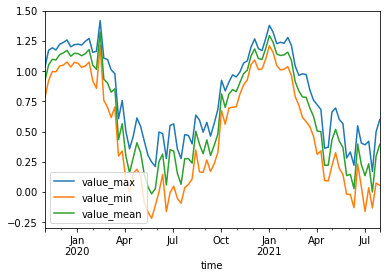

In [62]:
df_pred.resample('7D').mean().plot()

In [63]:
#exports
def plot_obsv_v_pred(
    s_observed: pd.Series, 
    s_prediction: pd.Series, 
    dpi: int=150, 
    s: float=0.4, 
    linewidth: float=0, 
    color: str='k', 
    **scatter_kwargs
):
    min_, max_ = min(s_observed.min(), s_prediction.min()), max(s_observed.max(), s_prediction.max())
    fig, ax = plt.subplots(dpi=dpi)

    ax.plot([min_, max_], [min_, max_], linewidth=1, color='r', zorder=0)
    ax.scatter(s_observed, s_prediction, s=s, linewidth=linewidth, color=color, **scatter_kwargs)

    ax.set_xlabel('Prediction')
    ax.set_ylabel('Observation')
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    
    return

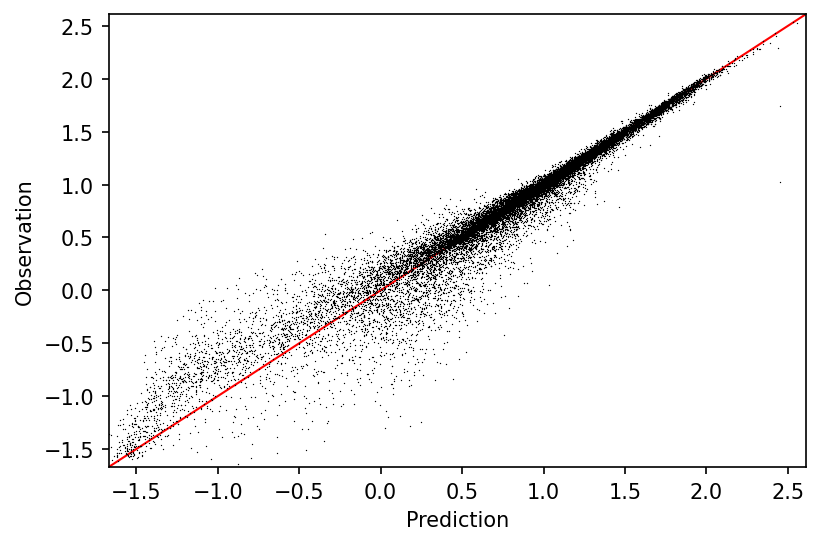

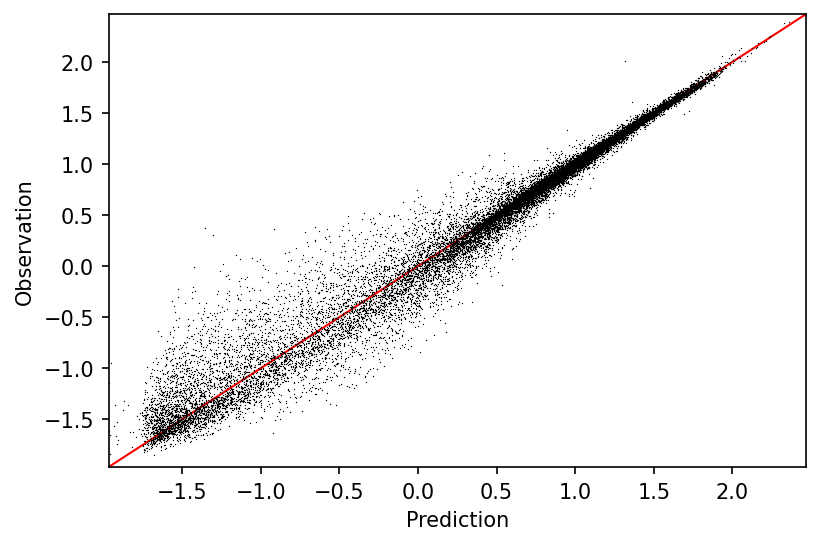

In [64]:
plot_obsv_v_pred(df_target['value_max'], df_pred['value_max'])
plot_obsv_v_pred(df_target['value_min'], df_pred['value_min'])

In [65]:
#exports
def create_residual_bin_avgs_s(
    s: pd.Series, 
    bins=np.linspace(-2.5, 2.5, 51)
): 
    bin_avg_values = np.mean(np.vstack((bins[1:], bins[:-1])), axis=0)
    s_residual_bin_avgs = s.groupby(pd.cut(s, bins=bins)).mean() - bin_avg_values
    s_residual_bin_avgs.index = bin_avg_values
    
    return s_residual_bin_avgs

def plot_residual_bin_avgs(df_pred: pd.DataFrame):
    s_min_residual_bin_avgs = create_residual_bin_avgs_s(df_pred['value_min']).dropna()
    s_max_residual_bin_avgs = create_residual_bin_avgs_s(df_pred['value_max']).dropna()

    # Plotting
    fig, ax = plt.subplots(dpi=150)

    s_min_residual_bin_avgs.plot(label='min', ax=ax)
    s_max_residual_bin_avgs.plot(label='max', ax=ax)

    ax.plot([-2.5, 2.5], [0, 0], color='k', linestyle='--', linewidth=1)
    
    ax.legend(frameon=False)
    ax.set_xlabel('Demand (MW)')
    ax.set_ylabel('Residuals Average (MW)')
    ax.set_xlim(
        min(s_min_residual_bin_avgs.index.min(), s_max_residual_bin_avgs.index.min()),
        max(s_min_residual_bin_avgs.index.max(), s_max_residual_bin_avgs.index.max())
    )

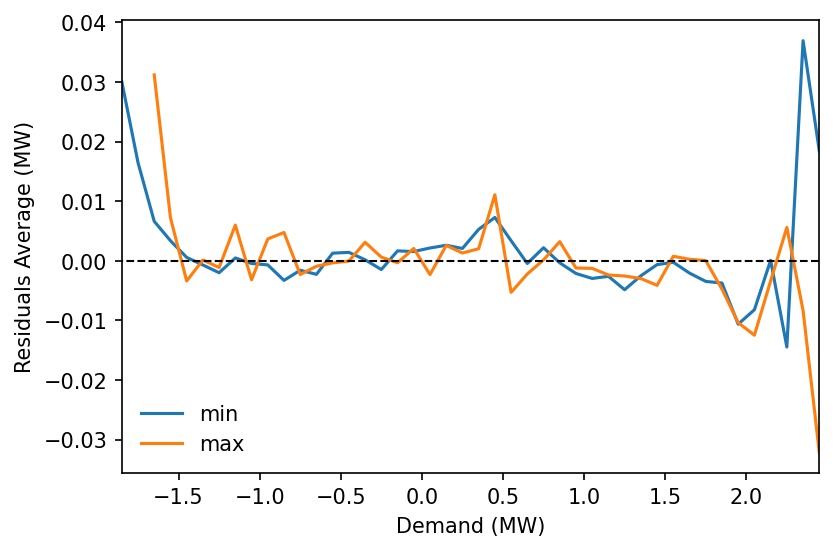

In [66]:
plot_residual_bin_avgs(df_pred)

In [67]:
#exports
flatten_list = lambda list_: [item for sublist in list_ for item in sublist]

def plot_pred_sample(
    df_pred: pd.DataFrame,
    df_target: pd.DataFrame=None,
    n_obvs: int=48*5,
    subplot_kwargs: dict={'dpi': 150}
):
    fig, axs = plt.subplots(**subplot_kwargs)
    
    if isinstance(axs, np.ndarray):
        dims = len(axs.shape)
        axs = list(axs)
        
        if dims > 1:
            axs = flatten_list(axs)
        
    else:
        axs = [axs]
        
    for ax in axs:
        rand_start_idx = randint(0, df_pred.shape[0]-1)  
        rand_end_idx = rand_start_idx + n_obvs
    
        df_pred.iloc[rand_start_idx:rand_end_idx][['value_max', 'value_min']].plot(ax=ax, legend=False)

        if df_target is not None:
            df_target.iloc[rand_start_idx:rand_end_idx][['value_max', 'value_min']].plot(ax=ax, color='k', linestyle='--', linewidth=0.5, legend=False)

        ax.set_xlabel('')
        ax.set_ylabel('Net Demand (MW)')
        
    fig.tight_layout()

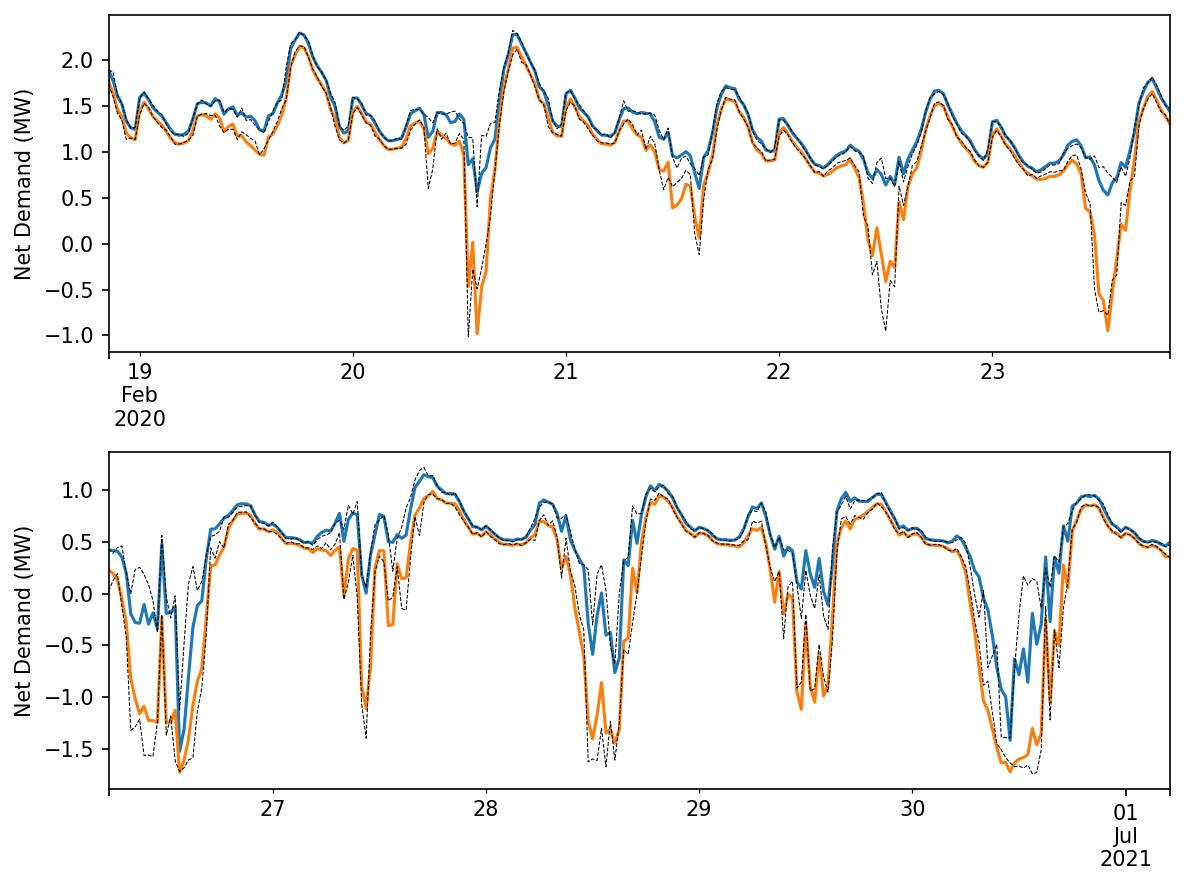

In [68]:
plot_pred_sample(df_pred, df_target, subplot_kwargs={'figsize': (8, 6), 'dpi': 150, 'nrows': 2})

In [69]:
#exports
def plot_residuals_dist(
    df_pred: pd.DataFrame,
    df_target: pd.DataFrame
):
    df_residuals = df_target.subtract(df_pred).dropna(axis=1)

    # Plotting
    fig, ax = plt.subplots(dpi=150)

    sns.histplot(df_residuals['value_max'], ax=ax, alpha=0.5, binwidth=0.025, linewidth=0, label='Max')
    sns.histplot(df_residuals['value_min'], ax=ax, alpha=0.5, binwidth=0.025, linewidth=0, label='Min', color='C1')

    ax.set_xlim(-2, 2)
    ax.set_yscale('log')
    ax.legend(frameon=False)
    ax.set_xlabel('Residuals (MW)')
    
    return 

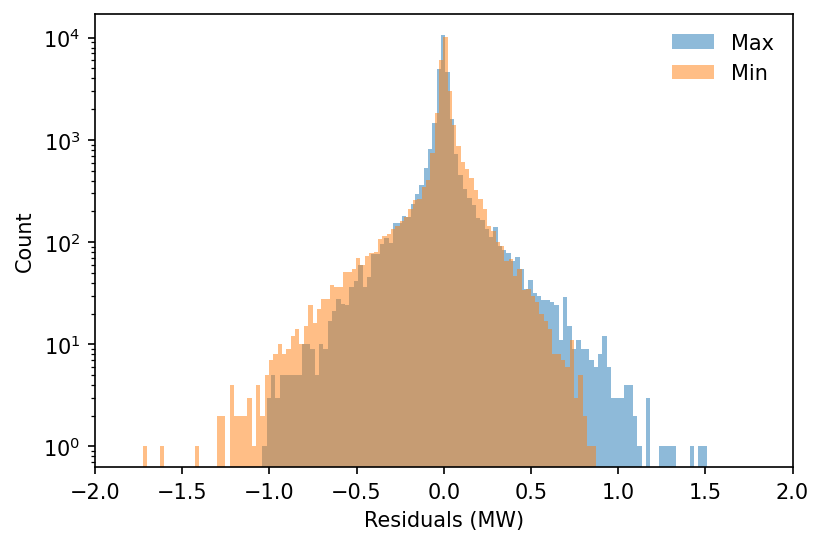

In [70]:
plot_residuals_dist(df_pred, df_target)

In [71]:
#exports
def visualise_errors(df_pred: pd.DataFrame, df_target: pd.DataFrame):
    plot_obsv_v_pred(df_target['value_max'], df_pred['value_max'])
    plot_obsv_v_pred(df_target['value_min'], df_pred['value_min'])
    
    plot_residual_bin_avgs(df_pred)
    plot_residuals_dist(df_pred, df_target)
    
    return

In [73]:
# visualise_errors(df_pred, df_target)

<br>

### Parameter Management

In [9]:
#exports
def save_params(input_data, fp):
    with open(fp, 'w') as f:
        yaml.dump(input_data, f, sort_keys=False)
        
    return

In [11]:
fp = '../data/params/test.yml'
save = False

if save == True:
    save_params(input_data, fp)

In [12]:
#exports
def load_params(fp):
    with open(fp, 'r') as f:
        input_data = yaml.load(f, Loader=yaml.FullLoader)
        
    return input_data

In [13]:
input_data = load_params(fp)
    
JSON(input_data)

<IPython.core.display.JSON object>

In [24]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 01-data-processing.ipynb.
Converted 02-spatial-analysis.ipynb.
Converted 03a-feature-generation.ipynb.
Converted 03b-eda.ipynb.
Converted 04-model-suite.ipynb.
Converted 05-custom-models.ipynb.
Converted 06-submission.ipynb.
Converted 07-experiments.ipynb.
Converted 08-testing.ipynb.
